In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import IsolationForest

df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

# mccinfo sütunundan dört haneli değeri çekmek için fonksiyon
def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Numerik sütunların formatlanması
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunlar için etiketleme
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Hedef ve özniteliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]

# Verilerin ölçeklendirilmesi
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

mccinfo değeri bulunamadığı için silinecek satır sayısı: 15


In [2]:

# Tüm verisetine Isolation Forest uygulayarak outlier'ları temizliyoruz
if_model = IsolationForest(contamination="auto", random_state=42)
outlier_pred = if_model.fit_predict(X_scaled)
inliers_mask = outlier_pred == 1
num_outliers = np.sum(~inliers_mask)
print(f"Tüm verisetindet {num_outliers} adet outlier tespit edildi")

X_scaled_clean = X_scaled[inliers_mask].copy()
y_clean = y[inliers_mask]

Tüm verisetindet 289 adet outlier tespit edildi


In [3]:
# Temizlenmiş verisetine KMeans ile kümeleme uygulanıyor.
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters_clean = kmeans.fit_predict(X_scaled_clean)
X_scaled_clean['Cluster'] = clusters_clean

print("Kümeleme işlemi tamamlandı. Küme dağılımı:")
print(pd.Series(clusters_clean).value_counts())


Kümeleme işlemi tamamlandı. Küme dağılımı:
2    306
3    271
0    230
1    225
5    201
4    170
Name: count, dtype: int64


c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\yagiz\anaconda3\envs\img\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\yagiz\anaconda3\envs\img\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\yagiz\anaconda3\envs\img\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
c

In [4]:

# ELMRegressor sınıfı
class ELMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_hidden=50, activation='sigmoid', random_state=42, reg_alpha=0.0):
        """
        reg_alpha: Ridge regularization parametresi. 0.0 ise regularizasyon uygulanmaz.
        """
        self.n_hidden = n_hidden
        self.activation = activation
        self.random_state = random_state
        self.reg_alpha = reg_alpha

    def _activation(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Bilinmeyen aktivasyon fonksiyonu.")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        rng = np.random.RandomState(self.random_state)

        # Rastgele input ağırlıkları ve bias değerleri oluşturuluyor
        self.input_weights_ = rng.randn(n_features, self.n_hidden)
        self.bias_ = rng.randn(self.n_hidden)

        # Gizli katmanın çıktısı hesaplanıyor
        H = self._activation(np.dot(X, self.input_weights_) + self.bias_)

        # Ridge regularizasyon
        if self.reg_alpha > 0:
            I = np.eye(H.shape[1])
            self.beta_ = np.linalg.inv(H.T.dot(H) + self.reg_alpha * I).dot(H.T).dot(y)
        else:
            self.beta_ = np.linalg.pinv(H).dot(y)
        return self

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights_) + self.bias_)
        return np.dot(H, self.beta_)

# Tüm tahminleri ve küme bazlı metrikleri saklamak için değişkenler
all_predictions = pd.Series(index=y_clean.index, dtype=float)
cluster_metrics = {}

# Her küme için model eğitimi
for cluster in np.unique(clusters_clean):
    print(f"\nCluster {cluster} için model eğitimi başlatılıyor...")
    cluster_mask = X_scaled_clean['Cluster'] == cluster
    X_cluster = X_scaled_clean.loc[cluster_mask].drop(columns=['Cluster'])
    y_cluster = y_clean.loc[cluster_mask]
    
    # Kümedeki örnek sayısına göre KFold ayarlanıyor.
    if len(X_cluster) < 10:
        print(f"Uyarı: Cluster {cluster} için örnek sayısı {len(X_cluster)}, CV kat sayısı örnek sayısına göre ayarlanıyor.")
        kf = KFold(n_splits=len(X_cluster), shuffle=True, random_state=321)
    else:
        kf = KFold(n_splits=10, shuffle=True, random_state=124)
    
    # Pipeline: Özellik seçimi ve ELMRegressor
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
        ('elm', ELMRegressor(n_hidden=25, activation='relu', reg_alpha=1, random_state=124))
    ])
    
    # Cross validation ile tahminler
    y_pred_cluster = cross_val_predict(pipeline, X_cluster, y_cluster, cv=kf)
    
    mae = mean_absolute_error(y_cluster, y_pred_cluster)
    mape = mean_absolute_percentage_error(y_cluster, y_pred_cluster)
    r2 = r2_score(y_cluster, y_pred_cluster)
    
    cluster_metrics[cluster] = {'MAE': mae, 'MAPE': mape, 'R2': r2}
    print(f"Cluster {cluster} sonuçları:")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R2: {r2:.4f}")
    
    # Bu kümedeki tahminleri, orijinal indeksleriyle saklıyoruz.
    all_predictions.loc[X_cluster.index] = y_pred_cluster

print("\nTüm kümeler için model sonuçları:")
print(cluster_metrics)

# Genel metriklerin hesaplanması
valid_indices = all_predictions.dropna().index
overall_mae = mean_absolute_error(y_clean.loc[valid_indices], all_predictions.dropna())
overall_mape = mean_absolute_percentage_error(y_clean.loc[valid_indices], all_predictions.dropna())
overall_r2 = r2_score(y_clean.loc[valid_indices], all_predictions.dropna())

print("\nGenel model sonuçları (sadece inlier'lar için):")
print(f"Genel MAE: {overall_mae:.4f}")
print(f"Genel MAPE: {overall_mape:.4f}")
print(f"Genel R2: {overall_r2:.4f}")




Cluster 0 için model eğitimi başlatılıyor...
Cluster 0 sonuçları:
MAE: 0.5182
MAPE: 0.1163
R2: 0.0015

Cluster 1 için model eğitimi başlatılıyor...
Cluster 1 sonuçları:
MAE: 0.4191
MAPE: 0.0953
R2: 0.1191

Cluster 2 için model eğitimi başlatılıyor...
Cluster 2 sonuçları:
MAE: 0.5500
MAPE: 0.1395
R2: 0.1151

Cluster 3 için model eğitimi başlatılıyor...
Cluster 3 sonuçları:
MAE: 0.5602
MAPE: 0.1300
R2: 0.1327

Cluster 4 için model eğitimi başlatılıyor...
Cluster 4 sonuçları:
MAE: 0.4684
MAPE: 0.1093
R2: 0.0398

Cluster 5 için model eğitimi başlatılıyor...
Cluster 5 sonuçları:
MAE: 0.5175
MAPE: 0.1185
R2: 0.1084

Tüm kümeler için model sonuçları:
{0: {'MAE': 0.5181687335341891, 'MAPE': 0.11634811466523685, 'R2': 0.001492958909455111}, 1: {'MAE': 0.41912652309891135, 'MAPE': 0.09525011367614938, 'R2': 0.11910712874389584}, 2: {'MAE': 0.5500324954645212, 'MAPE': 0.13953820108313028, 'R2': 0.11508532696082796}, 3: {'MAE': 0.5602050866102005, 'MAPE': 0.1299926591547195, 'R2': 0.1327133872097

c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\feature_

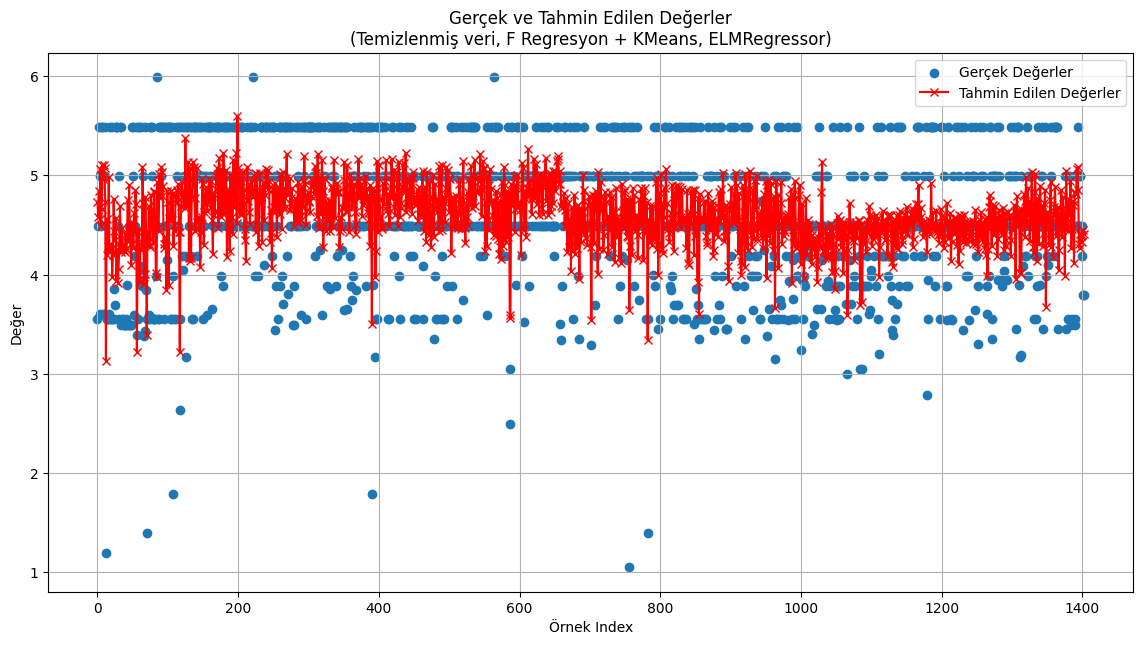

In [5]:
plt.figure(figsize=(14,7))
plt.scatter(np.arange(len(valid_indices)), y_clean.loc[valid_indices], label="Gerçek Değerler", marker="o")
plt.plot(np.arange(len(valid_indices)), all_predictions.loc[valid_indices].sort_index(), 
         label="Tahmin Edilen Değerler", marker="x", color="red", linestyle="-")
plt.xlabel("Örnek Index")
plt.ylabel("Değer")
plt.title("Gerçek ve Tahmin Edilen Değerler\n(Temizlenmiş veri, F Regresyon + KMeans, ELMRegressor)")
plt.legend()
plt.grid(True)
plt.show()
